In [1]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from scipy.ndimage import rotate as scipyrotate
from networks import MLP, ConvNet
from utils import *
from ptflops import get_model_complexity_info
from torchvision.utils import save_image
import copy
import matplotlib.pyplot as plt
from thop import profile
import torchrl

# TASK 1
# MNIST

In [41]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, MNIST_testloader, MNIST_trainloader = get_dataset(dataset = 'MNIST', data_path = "MNIST_Dataset")

In [43]:
dst_train[0][1]

5

In [3]:
# net_width, net_depth, net_act, net_norm, net_pooling = get_default_convnet_setting()

net = get_network(model = "ConvNetD3" , channel = 1, num_classes = 10, im_size=(28, 28))

In [5]:
net.parameters

<bound method Module.parameters of ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)>

In [4]:
args = {'dis_metric' : 'cos',
        "device" : "cuda",
        "lr_net" : 0.01, #etaTheta
        "epoch_eval_train" : 20,
        "batch_train" : 256,
        "ipc" : 10,
        "num_eval" : 50,
        "init" : "real",
        "eval_mode" : "S",
        "Iteration" : 20,
        # "Iteration" : 2, 
        "lr_img" : 0.1, # etaS
        "dsa_strategy" : None,
        "method" : "DC",
        "num_exp" : 1,
        "save_path" : "results_path_MNIST",
        "data_path" : "MNIST_Dataset",
        "model" : "ConvNetD3",
        "dataset" : "MNIST",
        "batch_real" : 256,
        "batch_syn" : 25
         }

# args["dsa"] = True if args["method"] == 'DSA' else False
args["dsa"] = False
args["outer_loop"], args["inner_loop"] = get_loops(args["ipc"])
args["dsa_param"] = ParamDiffAug()
print("outer_loop = {}, inner_loop = {}".format(args["outer_loop"], args["inner_loop"]))

outer_loop = 10, inner_loop = 50


In [2]:
def calc_flops(dataloader):
    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(args["device"])
        flops, params = profile(net.to(args["device"]), inputs=(img,))
        print(f"FLOPS: {flops / 1e9:.2f} GFLOPs")
    print(f"Number of parameters: {params / 1e6:.2f} million")
    return flops, params   

### 2(a) Training Convnet 3 with full training set

In [40]:
train_acc, test_acc = [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = MNIST_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    test_loss_avg, test_acc_avg = epoch(mode = 'test', dataloader = MNIST_testloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)
    print("Epoch = {}, Training Loss = {}, Training Accuracy = {}, Test Loss = {}, Test Accuracy = {}".format(ep, train_loss_avg, train_acc_avg, test_loss_avg, test_acc_avg ))

Epoch = 1, Training Loss = 1.3819134176254273, Training Accuracy = 0.7411, Test Loss = 0.9831620448430379, Test Accuracy = 0.7048166666666666
Epoch = 2, Training Loss = 0.6155954173088074, Training Accuracy = 0.9135, Test Loss = 0.5508746850331624, Test Accuracy = 0.8841166666666667
Epoch = 3, Training Loss = 0.3762314003944397, Training Accuracy = 0.942, Test Loss = 0.399486566956838, Test Accuracy = 0.9234666666666667
Epoch = 4, Training Loss = 0.27403317995071413, Training Accuracy = 0.9547, Test Loss = 0.27779482305844627, Test Accuracy = 0.94685
Epoch = 5, Training Loss = 0.2176873903274536, Training Accuracy = 0.96, Test Loss = 0.24274734948476157, Test Accuracy = 0.94985
Epoch = 6, Training Loss = 0.18413085715770722, Training Accuracy = 0.9646, Test Loss = 0.19935914470354715, Test Accuracy = 0.9591333333333333
Epoch = 7, Training Loss = 0.1602578280210495, Training Accuracy = 0.9689, Test Loss = 0.19676877969106038, Test Accuracy = 0.9556833333333333
Epoch = 8, Training Loss =

### FLOPS on Test Set

In [10]:
test_flops, testparams = calc_flops(MNIST_testloader)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPS: 12.40 GFLOPs
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPS: 12.40 GFLOPs
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() 

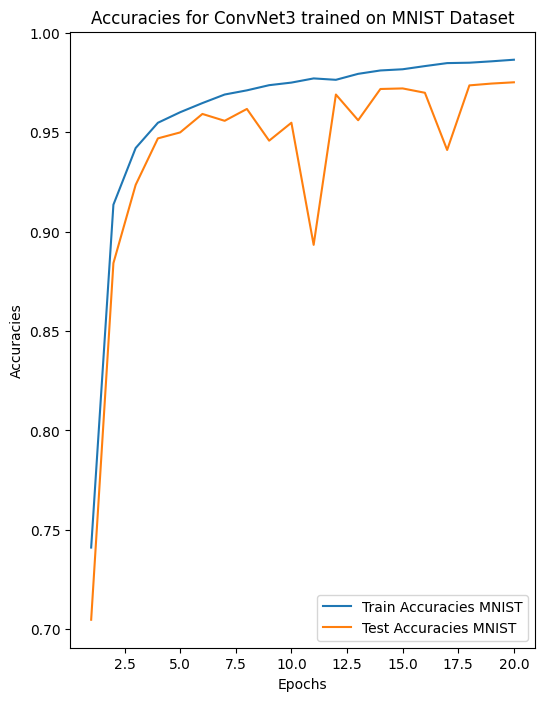

In [42]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), train_acc, label = "Train Accuracies MNIST")
plt.plot(range(1,21), test_acc, label =  "Test Accuracies MNIST")
plt.title("Accuracies for ConvNet3 trained on MNIST Dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc = "best")
plt.show()

### 2(b) Syntehtic Dataset using real images

### MNIST With Real Images

In [51]:
args = {'dis_metric' : 'cos',
        "device" : "cuda",
        "lr_net" : 0.01, #etaTheta
        "epoch_eval_train" : 20,
        "batch_train" : 256,
        "ipc" : 10,
        "num_eval" : 50,
        "init" : "real",
        "eval_mode" : "S",
        "Iteration" : 20,
        # "Iteration" : 2, 
        "lr_img" : 0.1, # etaS
        "dsa_strategy" : None,
        "method" : "DC",
        "num_exp" : 1,
        "save_path" : "results_path_MNIST",
        "data_path" : "MNIST_Dataset",
        "model" : "ConvNetD3",
        "dataset" : "MNIST",
        "batch_real" : 256,
        "batch_syn" : 25
         }

# args["dsa"] = True if args["method"] == 'DSA' else False
args["dsa"] = False
args["outer_loop"], args["inner_loop"] = get_loops(args["ipc"])
args["dsa_param"] = ParamDiffAug()
print("outer_loop = {}, inner_loop = {}".format(args["outer_loop"], args["inner_loop"]))

outer_loop = 10, inner_loop = 50


In [53]:
args["init"] = "real"
data_save = []
print('Hyper-parameters: \n', args)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args["device"])
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args["device"])

for c in range(num_classes):
    print('class c =  %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args["ipc"], channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args["device"])
label_syn = torch.tensor(np.asarray([np.ones(args["ipc"])*i for i in range(num_classes)]), dtype=torch.long, requires_grad=False, device=args["device"]).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args["init"] == 'real':
    print('initialize synthetic data from random real images')
    for c in range(num_classes):
        image_syn.data[c*args["ipc"]:(c+1)*args["ipc"]] = get_images(c, args["ipc"]).detach().data
else:
    print('initialize synthetic data from random noise')


''' training '''
# optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"], momentum=0.5) # optimizer_img for synthetic data
optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"]) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args["device"])

print('%s training begins'%get_time())

for it in range(args["Iteration"]+1):


    ''' visualize and save '''
    # print("Visualizing the datatset")
    save_name = fr'{args["save_path"]}/' + 'vis_%s_%s_%s_bs%d_init_%s_%dipc_iter%d.png'%(args["method"], args["dataset"], args["model"], args["batch_syn"], args["init"], args["ipc"], it)
    image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
    for ch in range(channel):
        image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
    image_syn_vis[image_syn_vis<0] = 0.0
    image_syn_vis[image_syn_vis>1] = 1.0
    save_image(image_syn_vis, save_name, nrow=args["ipc"]) # Trying normalize = True/False may get better visual effects.
    # print("Synthetic datataset visualization saved")


    ''' Train synthetic data '''
    # print("Training Synthetic Datatset")
    net = get_network(args["model"], channel, num_classes, im_size).to(args["device"]) # get a random model
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=args["lr_net"])  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0
    # args["dc_aug_param"] = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.


    for ol in range(args["outer_loop"]):
        # print("outer loop epoch {}".format(ol))

        ''' update synthetic data '''
        # print("updating synthetic data")
        loss = torch.tensor(0.0).to(args["device"])
        for c in range(num_classes):
            img_real = get_images(c, args["batch_real"])
            lab_real = torch.ones((img_real.shape[0],), device=args["device"], dtype=torch.long) * c
            img_syn = image_syn[c*args["ipc"]:(c+1)*args["ipc"]].reshape((args["ipc"], channel, im_size[0], im_size[1]))
            lab_syn = torch.ones((args["ipc"],), device=args["device"], dtype=torch.long) * c


            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real, args)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step() # img optimiziner step size  = 1
        loss_avg += loss.item()

        if ol == args["outer_loop"] - 1:
            break


        ''' update network '''
        # print("updating network")
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        mnist_syn_trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=args["batch_syn"], shuffle=True, num_workers=0)
        for il in range(args["inner_loop"]):
            train_loss_avg, _ = epoch('train', mnist_syn_trainloader, net, optimizer_net, criterion, args, aug = False, optimization_steps= 50 )
            # train_loss_avg, _ = epoch('train', mnist_syn_trainloader, net, optimizer_net, criterion, args, aug = False, optimization_steps= None )

    loss_avg /= (num_classes*args["outer_loop"])

    print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))

    if it == args["Iteration"]: # only record the final results
        data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])
        torch.save({'data': data_save}, fr'{args["save_path"]}/' +  'res_%s_%s_%s_bs%d_init_%s_%dipc.pt'%(args["method"], args["dataset"], args["model"], args["batch_syn"],args["init"], args["ipc"]))


print('\n==================== Synthetic Datatset Created ====================\n')


Hyper-parameters: 
 {'dis_metric': 'cos', 'device': 'cuda', 'lr_net': 0.01, 'epoch_eval_train': 20, 'batch_train': 256, 'ipc': 10, 'num_eval': 50, 'init': 'real', 'eval_mode': 'S', 'Iteration': 20, 'lr_img': 0.1, 'dsa_strategy': None, 'method': 'DC', 'num_exp': 1, 'save_path': 'results_path', 'data_path': 'MNIST_Dataset', 'model': 'ConvNetD3', 'dataset': 'MNIST', 'batch_real': 256, 'batch_syn': 25, 'dsa': False, 'outer_loop': 10, 'inner_loop': 50, 'dsa_param': <utils.ParamDiffAug object at 0x0000024974DCD400>}
class c =  0: 5923 real images
class c =  1: 6742 real images
class c =  2: 5958 real images
class c =  3: 6131 real images
class c =  4: 5842 real images
class c =  5: 5421 real images
class c =  6: 5918 real images
class c =  7: 6265 real images
class c =  8: 5851 real images
class c =  9: 5949 real images
initialize synthetic data from random real images
[2023-12-08 15:21:48] training begins
[2023-12-08 15:22:01] iter = 0000, loss = 0.1312
[2023-12-08 15:22:15] iter = 0001, lo

### Sample from synthetic dataset

Feature batch shape: torch.Size([25, 1, 28, 28])
Labels batch shape: torch.Size([25])


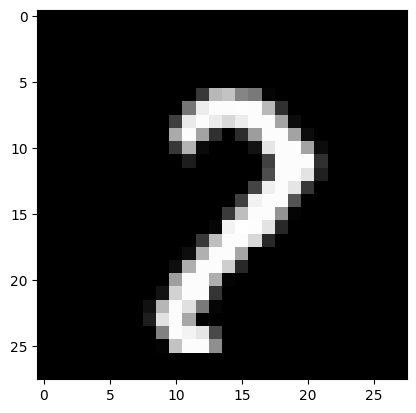

Label: 7


In [15]:
# Display image and label.
train_features, train_labels = next(iter(mnist_syn_trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.cpu().data.numpy(), cmap="gray")
plt.show()
print(f"Label: {label}")

### 2(e) Training ConvNet3 using synthetic dataset from real images

In [36]:
net = get_network(model = "ConvNetD3" , channel = 1, num_classes = 10, im_size=(28, 28))

In [37]:
train_acc, test_acc_condensed = [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = mnist_syn_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    test_loss_avg, test_acc_avg = epoch(mode = 'test', dataloader = MNIST_testloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    test_acc_condensed.append(test_acc_avg)
    print("Epoch = {}, Test Loss = {}, Test Accuracy = {}".format(ep, test_loss_avg, test_acc_avg ))

Epoch = 1, Test Loss = 2.026454571533203, Test Accuracy = 0.4110666666666667
Epoch = 2, Test Loss = 1.791367394510905, Test Accuracy = 0.5489166666666667
Epoch = 3, Test Loss = 1.6747090967814127, Test Accuracy = 0.5470166666666667
Epoch = 4, Test Loss = 1.4716487194697063, Test Accuracy = 0.7222333333333333
Epoch = 5, Test Loss = 1.4026274358113606, Test Accuracy = 0.6469666666666667
Epoch = 6, Test Loss = 1.2618727535247802, Test Accuracy = 0.7231833333333333
Epoch = 7, Test Loss = 1.200858481280009, Test Accuracy = 0.7025833333333333
Epoch = 8, Test Loss = 1.1113044500350953, Test Accuracy = 0.7373666666666666
Epoch = 9, Test Loss = 1.0087589246749877, Test Accuracy = 0.8080166666666667
Epoch = 10, Test Loss = 0.941133101717631, Test Accuracy = 0.8275666666666667
Epoch = 11, Test Loss = 0.8964750862439473, Test Accuracy = 0.8336166666666667
Epoch = 12, Test Loss = 0.8627600512186686, Test Accuracy = 0.8225
Epoch = 13, Test Loss = 0.8436589254697164, Test Accuracy = 0.8149
Epoch = 14

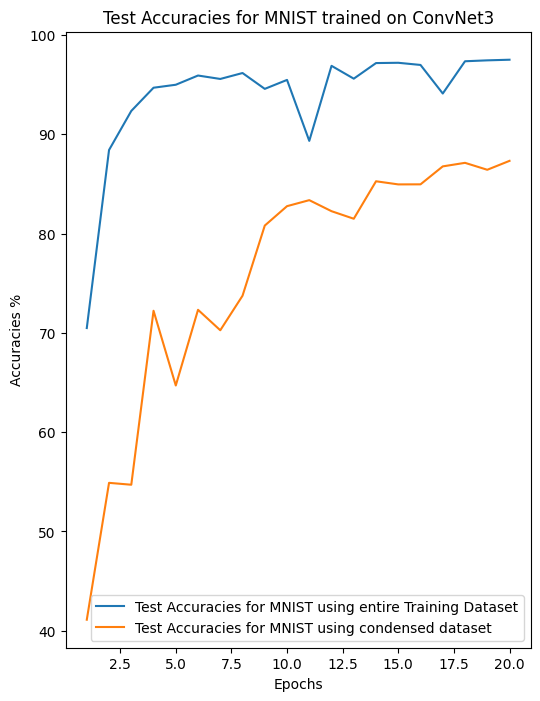

In [46]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), [i * 100 for i in test_acc], label =  "Test Accuracies for MNIST using entire Training Dataset")
plt.plot(range(1,21), [i * 100 for i in test_acc_condensed], label =  "Test Accuracies for MNIST using condensed dataset")
plt.title("Test Accuracies for MNIST trained on ConvNet3")
plt.xlabel("Epochs")
plt.ylabel("Accuracies %")
plt.legend(loc = "best")
plt.show()

### MNIST With Gaussian Noise

In [24]:
args["init"] = "noise"
data_save = []
print('Hyper-parameters: \n', args)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args["device"])
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args["device"])

for c in range(num_classes):
    print('class c =  %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args["ipc"], channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args["device"])
label_syn = torch.tensor(np.asarray([np.ones(args["ipc"])*i for i in range(num_classes)]), dtype=torch.long, requires_grad=False, device=args["device"]).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args["init"] == 'real':
    print('initialize synthetic data from random real images')
    for c in range(num_classes):
        image_syn.data[c*args["ipc"]:(c+1)*args["ipc"]] = get_images(c, args["ipc"]).detach().data
else:
    print('initialize synthetic data from random noise')


''' training '''
# optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"], momentum=0.5) # optimizer_img for synthetic data
optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"]) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args["device"])

print('%s training begins'%get_time())

for it in range(args["Iteration"]+1):


    ''' visualize and save '''
    # print("Visualizing the datatset")
    save_name = fr'{args["save_path"]}/' + 'vis_%s_%s_%s_bs%d_init_%s_%dipc_iter%d.png'%(args["method"], args["dataset"], args["model"], args["batch_syn"], args["init"], args["ipc"], it)
    image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
    for ch in range(channel):
        image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
    image_syn_vis[image_syn_vis<0] = 0.0
    image_syn_vis[image_syn_vis>1] = 1.0
    save_image(image_syn_vis, save_name, nrow=args["ipc"]) # Trying normalize = True/False may get better visual effects.
    # print("Synthetic datataset visualization saved")


    ''' Train synthetic data '''
    # print("Training Synthetic Datatset")
    net = get_network(args["model"], channel, num_classes, im_size).to(args["device"]) # get a random model
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=args["lr_net"])  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0
    # args["dc_aug_param"] = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.


    for ol in range(args["outer_loop"]):
        # print("outer loop epoch {}".format(ol))

        ''' update synthetic data '''
        # print("updating synthetic data")
        loss = torch.tensor(0.0).to(args["device"])
        for c in range(num_classes):
            img_real = get_images(c, args["batch_real"])
            lab_real = torch.ones((img_real.shape[0],), device=args["device"], dtype=torch.long) * c
            img_syn = image_syn[c*args["ipc"]:(c+1)*args["ipc"]].reshape((args["ipc"], channel, im_size[0], im_size[1]))
            lab_syn = torch.ones((args["ipc"],), device=args["device"], dtype=torch.long) * c


            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real, args)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step() # img optimiziner step size  = 1
        loss_avg += loss.item()

        if ol == args["outer_loop"] - 1:
            break


        ''' update network '''
        # print("updating network")
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        mnist_syn_trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=args["batch_syn"], shuffle=True, num_workers=0)
        for il in range(args["inner_loop"]):
            train_loss_avg, _ = epoch('train', mnist_syn_trainloader, net, optimizer_net, criterion, args, aug = False, optimization_steps= 50 )
            # train_loss_avg, _ = epoch('train', trainloader, net, optimizer_net, criterion, args, aug = False)

    loss_avg /= (num_classes*args["outer_loop"])

    print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))

    if it == args["Iteration"]: # only record the final results
        data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])
        torch.save({'data': data_save}, fr'{args["save_path"]}/' +  'res_%s_%s_%s_bs%d_init_%s_%dipc.pt'%(args["method"], args["dataset"], args["model"], args["batch_syn"],args["init"], args["ipc"]))


print('\n==================== Synthetic Datatset Created ====================\n')


Hyper-parameters: 
 {'dis_metric': 'cos', 'device': 'cuda', 'lr_net': 0.01, 'epoch_eval_train': 20, 'batch_train': 256, 'ipc': 10, 'num_eval': 50, 'init': 'noise', 'eval_mode': 'S', 'Iteration': 20, 'lr_img': 0.1, 'dsa_strategy': None, 'method': 'DC', 'num_exp': 1, 'save_path': 'results_path', 'data_path': 'MNIST_Dataset', 'model': 'ConvNetD3', 'dataset': 'MNIST', 'batch_real': 256, 'batch_syn': 25, 'dsa': False, 'outer_loop': 10, 'inner_loop': 50, 'dsa_param': <utils.ParamDiffAug object at 0x0000024971811580>}
class c =  0: 5923 real images
class c =  1: 6742 real images
class c =  2: 5958 real images
class c =  3: 6131 real images
class c =  4: 5842 real images
class c =  5: 5421 real images
class c =  6: 5918 real images
class c =  7: 6265 real images
class c =  8: 5851 real images
class c =  9: 5949 real images
initialize synthetic data from random noise
[2023-12-08 12:58:02] training begins


c:\Users\Saumya\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[2023-12-08 12:58:11] iter = 0000, loss = 0.3362
[2023-12-08 12:58:20] iter = 0001, loss = 0.3326
[2023-12-08 12:58:28] iter = 0002, loss = 0.3182
[2023-12-08 12:58:37] iter = 0003, loss = 0.3213
[2023-12-08 12:58:46] iter = 0004, loss = 0.3175
[2023-12-08 12:58:55] iter = 0005, loss = 0.3448
[2023-12-08 12:59:04] iter = 0006, loss = 0.3208
[2023-12-08 12:59:13] iter = 0007, loss = 0.3308
[2023-12-08 12:59:22] iter = 0008, loss = 0.3275
[2023-12-08 12:59:32] iter = 0009, loss = 0.3324
[2023-12-08 12:59:41] iter = 0010, loss = 0.3316
[2023-12-08 12:59:50] iter = 0011, loss = 0.3310
[2023-12-08 12:59:59] iter = 0012, loss = 0.3279
[2023-12-08 13:00:08] iter = 0013, loss = 0.3154
[2023-12-08 13:00:17] iter = 0014, loss = 0.3260
[2023-12-08 13:00:26] iter = 0015, loss = 0.3423
[2023-12-08 13:00:35] iter = 0016, loss = 0.3240
[2023-12-08 13:00:45] iter = 0017, loss = 0.3300
[2023-12-08 13:00:54] iter = 0018, loss = 0.3359
[2023-12-08 13:01:03] iter = 0019, loss = 0.3310
[2023-12-08 13:01:12

### Sample from Synthetic set

Feature batch shape: torch.Size([25, 1, 28, 28])
Labels batch shape: torch.Size([25])


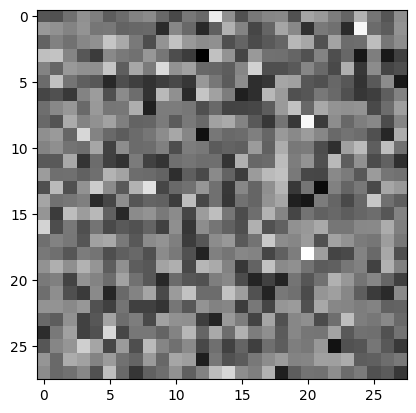

Label: 7


In [25]:
# Display image and label.
train_features, train_labels = next(iter(mnist_syn_trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.cpu().data.numpy(), cmap="gray")
plt.show()
print(f"Label: {label}")

### Train and test accuracies while training synthetic set using synthetic images initialized with gaussian noise

In [26]:
net = get_network(model = "ConvNetD3" , channel = 1, num_classes = 10, im_size=(28, 28))

In [27]:
train_acc, test_acc = [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = mnist_syn_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    test_loss_avg, test_acc_avg = epoch(mode = 'test', dataloader = MNIST_testloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    test_acc.append(test_acc_avg)
    print("Epoch = {}, Test Loss = {}, Test Accuracy = {}".format(ep, test_loss_avg, test_acc_avg ))

Epoch = 1, Test Loss = 2.3337374422709147, Test Accuracy = 0.1542
Epoch = 2, Test Loss = 2.3374623457590737, Test Accuracy = 0.09513333333333333
Epoch = 3, Test Loss = 2.3514587200164794, Test Accuracy = 0.1628
Epoch = 4, Test Loss = 2.343653874842326, Test Accuracy = 0.1433
Epoch = 5, Test Loss = 2.3499947546641033, Test Accuracy = 0.14148333333333332
Epoch = 6, Test Loss = 2.3734043000539145, Test Accuracy = 0.14385
Epoch = 7, Test Loss = 2.356509297053019, Test Accuracy = 0.13
Epoch = 8, Test Loss = 2.3536974604288736, Test Accuracy = 0.15363333333333334
Epoch = 9, Test Loss = 2.384888119379679, Test Accuracy = 0.12095
Epoch = 10, Test Loss = 2.396019682439168, Test Accuracy = 0.12033333333333333
Epoch = 11, Test Loss = 2.3904421240488687, Test Accuracy = 0.142
Epoch = 12, Test Loss = 2.4229362752278645, Test Accuracy = 0.12253333333333333
Epoch = 13, Test Loss = 2.4059793506622316, Test Accuracy = 0.15815
Epoch = 14, Test Loss = 2.4587498744964598, Test Accuracy = 0.0992
Epoch = 15

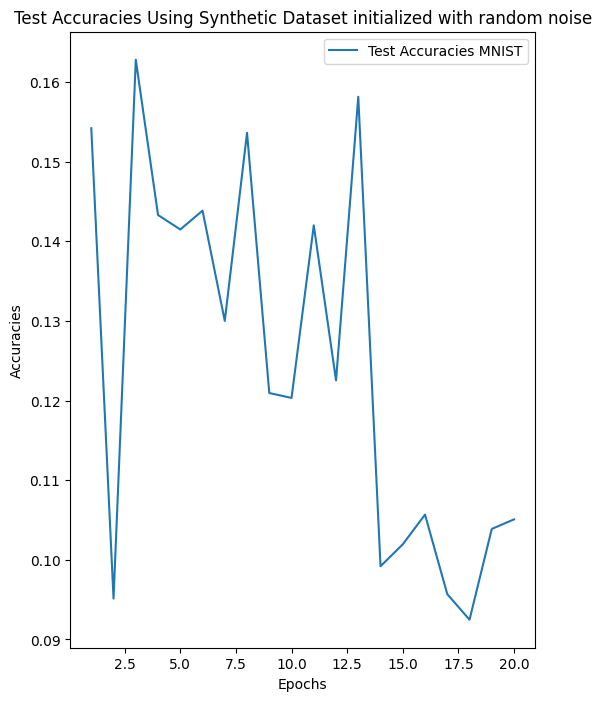

In [28]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), test_acc, label =  "Test Accuracies MNIST")
plt.title("Test Accuracies Using Synthetic Dataset initialized with random noise")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc = "best")
plt.show()

In [ ]:
net = get_network(model = "ConvNetD3" , channel = 1, num_classes = 10, im_size=(28, 28))

### Q3 Cross Architecture Generalzation

In [48]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, MNIST_testloader, MNIST_trainloader = get_dataset(dataset = 'MNIST', data_path = "MNIST_Dataset")

### Alexnet

In [2]:
net = get_network(model = "AlexNet" , channel = 1, num_classes = 10, im_size=(28, 28))

In [3]:
net.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)>

In [59]:
train_acc_alexnet, test_acc_alexnet = [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = mnist_syn_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=0.03), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    test_loss_avg, test_acc_avg = epoch(mode = 'test', dataloader = MNIST_testloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=0.03), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc_alexnet.append(train_acc_avg)
    test_acc_alexnet.append(test_acc_avg)
    print("Epoch = {}, Test Loss = {}, Test Accuracy = {}".format(ep, test_loss_avg, test_acc_avg ))

Epoch = 1, Test Loss = 2.298537241999308, Test Accuracy = 0.13758333333333334
Epoch = 2, Test Loss = 2.2952336462656655, Test Accuracy = 0.15326666666666666
Epoch = 3, Test Loss = 2.2917812953948973, Test Accuracy = 0.17243333333333333
Epoch = 4, Test Loss = 2.288019232813517, Test Accuracy = 0.18018333333333333
Epoch = 5, Test Loss = 2.283522426223755, Test Accuracy = 0.19266666666666668
Epoch = 6, Test Loss = 2.278394066874186, Test Accuracy = 0.19706666666666667
Epoch = 7, Test Loss = 2.2722400310516355, Test Accuracy = 0.18413333333333334
Epoch = 8, Test Loss = 2.2647150928497313, Test Accuracy = 0.20806666666666668
Epoch = 9, Test Loss = 2.2547455163319907, Test Accuracy = 0.2503
Epoch = 10, Test Loss = 2.2420257771809897, Test Accuracy = 0.20613333333333334
Epoch = 11, Test Loss = 2.2252887304941815, Test Accuracy = 0.26565
Epoch = 12, Test Loss = 2.204834283574422, Test Accuracy = 0.47645
Epoch = 13, Test Loss = 2.173023811976115, Test Accuracy = 0.3325
Epoch = 14, Test Loss = 2

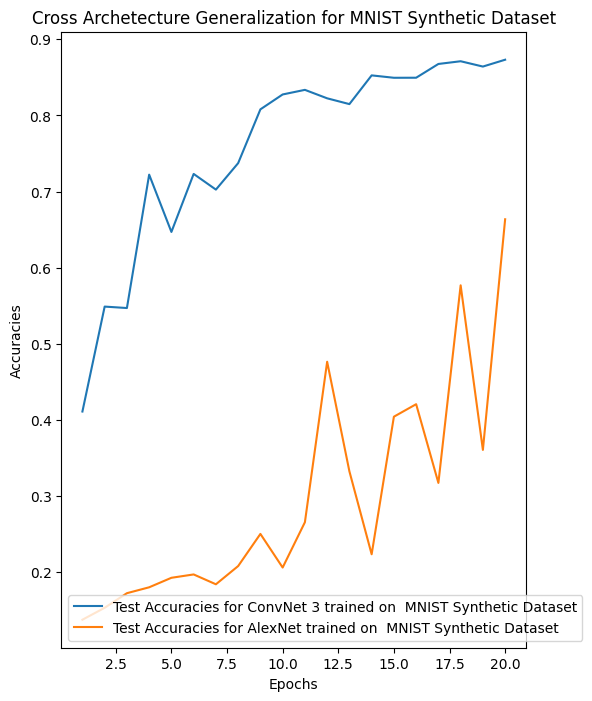

In [60]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), test_acc_condensed, label =  "Test Accuracies for ConvNet 3 trained on  MNIST Synthetic Dataset")
plt.plot(range(1,21), test_acc_alexnet, label =  "Test Accuracies for AlexNet trained on  MNIST Synthetic Dataset")
plt.title("Cross Archetecture Generalization for MNIST Synthetic Dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc = "best")
plt.show()

# MHIST

In [4]:
from sklearn.metrics import f1_score, roc_auc_score

In [11]:
args = {'dis_metric' : 'cos',
        "device" : "cuda",
        "lr_net" : 0.01, #etaTheta
        "epoch_eval_train" : 20,
        "batch_train" : 128,
        "ipc" : 50,
        "num_eval" : 50,
        "init" : "real",
        "eval_mode" : "S",
        "Iteration" : 1,
        # "Iteration" : 2, 
        "lr_img" : 0.1, # etaS
        "dsa_strategy" : None,
        "method" : "DC",
        "num_exp" : 1,
        "save_path" : "results_path_MHIST",
        "data_path" : "MHIST_Dataset",
        "model" : "ConvNetD7",
        "dataset" : "MHIST",
        "batch_real" : 128,
        "batch_syn" : 25
         }

# args["dsa"] = True if args["method"] == 'DSA' else False
args["dsa"] = False
args["outer_loop"], args["inner_loop"] = get_loops(args["ipc"])
args["dsa_param"] = ParamDiffAug()
print("outer_loop = {}, inner_loop = {}".format(args["outer_loop"], args["inner_loop"]))

outer_loop = 50, inner_loop = 10


The device on which the computation had to be done was changed to cpu from gpu for cetain trainings on the MHIST set, as my local CUDA was going out-of-memory

In [16]:
args["device"] = "cpu"

### Loading the MHIST dataset

In [17]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, MHIST_testloader, MHIST_trainloader = get_dataset(dataset = 'MHIST', data_path = None)

### Loading the Convnet7 network

In [7]:
net = get_network(model = "ConvNetD7" , channel = 3, num_classes = 2, im_size=(224, 224))

In [8]:
net.parameters

<bound method Module.parameters of ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(32, 32, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(32, 32, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(32, 32, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): GroupNorm(32, 32, eps=1e-05, affine=True)
    (14): ReLU(inplace=True)
    (15): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (16): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): Gro

### Training the Convnet7 on the entire MHIST Training Set

In [9]:
train_acc, auc_list, f1_list = [], [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = MHIST_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    auc = 0
    f1 = 0
    batch = 0

    for i_batch, datum in enumerate(MHIST_testloader):
        batch += 1
        img = datum[0].float().to(args["device"])
        lab = datum[1].long().to(args["device"])
        y_pred = np.argmax(torch.sigmoid(net(img)).cpu().data.numpy(), axis = -1)
        auc += roc_auc_score(lab.cpu().data.numpy(), y_pred)
        f1 += f1_score(lab.cpu().data.numpy(), y_pred,  average="weighted")

    auc_list.append(auc / batch)
    f1_list.append(f1 / batch)
    print("Epoch = {}, Training Loss = {}, Training Accuracy = {}, F1(Test set) = {}, AUC(Test Set) = {}".format(ep, train_loss_avg, train_acc_avg, f1 / batch, auc / batch))

Epoch = 1, Training Loss = 0.6180384251167035, Training Accuracy = 0.6806896551724138, F1(Test set) = 0.4867719012255891, AUC(Test Set) = 0.4977062287261569
Epoch = 2, Training Loss = 0.5897850812166586, Training Accuracy = 0.7105747126436781, F1(Test set) = 0.4872446245466063, AUC(Test Set) = 0.49842461953075456
Epoch = 3, Training Loss = 0.5814650643008878, Training Accuracy = 0.7110344827586207, F1(Test set) = 0.4872446245466063, AUC(Test Set) = 0.49842461953075456
Epoch = 4, Training Loss = 0.5726299149962677, Training Accuracy = 0.7114942528735633, F1(Test set) = 0.49926026670630413, AUC(Test Set) = 0.5048643344310526
Epoch = 5, Training Loss = 0.5656269165565228, Training Accuracy = 0.7137931034482758, F1(Test set) = 0.5021407456099345, AUC(Test Set) = 0.5064314302193549
Epoch = 6, Training Loss = 0.5593847401936849, Training Accuracy = 0.7181609195402299, F1(Test set) = 0.4970883897571972, AUC(Test Set) = 0.5038424283786589
Epoch = 7, Training Loss = 0.5508561847675806, Training

### Calculating FLOPS

In [15]:
test_flops, testparams = calc_flops(MHIST_testloader)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPS: 26.21 GFLOPs
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPS: 26.21 GFLOPs
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() 

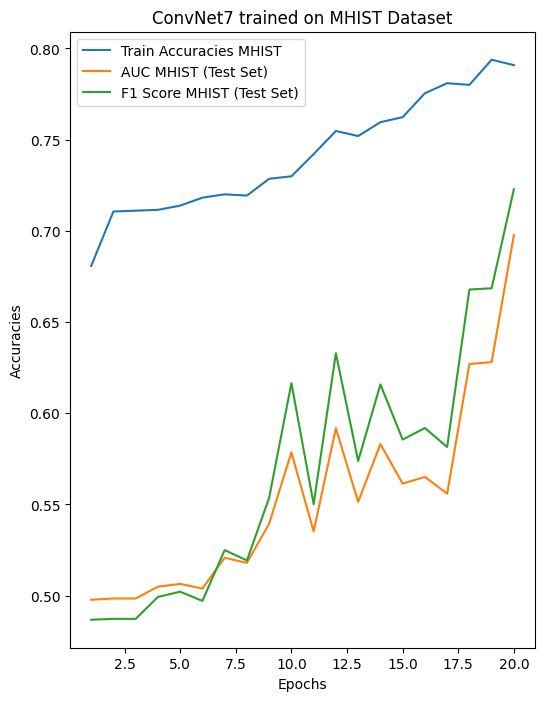

In [10]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), train_acc, label = "Train Accuracies MHIST")
plt.plot(range(1,21), auc_list, label =  "AUC MHIST (Test Set)")
plt.plot(range(1,21), f1_list, label =  "F1 Score MHIST (Test Set)")
plt.title("ConvNet7 trained on MHIST Dataset")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend(loc = "best")
plt.show()

In [23]:
args["device"] = "cuda"

### Generating Synthetic MHIST Dataset using synthetic dataset initialized by random real images

In [8]:
args["init"] = "real"
data_save = []
print('Hyper-parameters: \n', args)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1].item() for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args["device"])
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args["device"])

for c in range(num_classes):
    print('class c =  %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args["ipc"], channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args["device"])
label_syn = torch.tensor(np.asarray([np.ones(args["ipc"])*i for i in range(num_classes)]), dtype=torch.long, requires_grad=False, device=args["device"]).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args["init"] == 'real':
    print('initialize synthetic data from random real images')
    for c in range(num_classes):
        image_syn.data[c*args["ipc"]:(c+1)*args["ipc"]] = get_images(c, args["ipc"]).detach().data
else:
    print('initialize synthetic data from random noise')


''' training '''
# optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"], momentum=0.5) # optimizer_img for synthetic data
optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"]) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args["device"])

print('%s training begins'%get_time())

for it in range(args["Iteration"]+1):


    ''' visualize and save '''
    print("Visualizing the datatset")
    save_name = fr'{args["save_path"]}/' + 'vis_%s_%s_%s_bs%d_init_%s_%dipc_iter%d.png'%(args["method"], args["dataset"], args["model"], args["batch_syn"], args["init"], args["ipc"], it)
    image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
    for ch in range(channel):
        image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
    image_syn_vis[image_syn_vis<0] = 0.0
    image_syn_vis[image_syn_vis>1] = 1.0
    save_image(image_syn_vis, save_name, nrow=args["ipc"]) # Trying normalize = True/False may get better visual effects.
    # print("Synthetic datataset visualization saved")


    ''' Train synthetic data '''
    # print("Training Synthetic Datatset")
    net = get_network(args["model"], channel, num_classes, im_size).to(args["device"]) # get a random model
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=args["lr_net"])  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0
    # args["dc_aug_param"] = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.


    for ol in range(args["outer_loop"]):
        # print("outer loop epoch {}".format(ol))

        ''' update synthetic data '''
        # print("updating synthetic data")
        loss = torch.tensor(0.0).to(args["device"])
        for c in range(num_classes):
            img_real = get_images(c, args["batch_real"])
            lab_real = torch.ones((img_real.shape[0],), device=args["device"], dtype=torch.long) * c
            img_syn = image_syn[c*args["ipc"]:(c+1)*args["ipc"]].reshape((args["ipc"], channel, im_size[0], im_size[1]))
            lab_syn = torch.ones((args["ipc"],), device=args["device"], dtype=torch.long) * c


            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real, args)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step() # img optimiziner step size  = 1
        loss_avg += loss.item()

        if ol == args["outer_loop"] - 1:
            break


        ''' update network '''
        # print("updating network")
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        mhist_syn_trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=args["batch_syn"], shuffle=True, num_workers=0)
        for il in range(args["inner_loop"]):
            train_loss_avg, _ = epoch('train', mhist_syn_trainloader, net, optimizer_net, criterion, args, aug = False, optimization_steps= 50 )
            # train_loss_avg, _ = epoch('train', mnist_syn_trainloader, net, optimizer_net, criterion, args, aug = False, optimization_steps= None )
        print("Training for outer epoch {} is done".format(ol))

    loss_avg /= (num_classes*args["outer_loop"])

    print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))

    if it == args["Iteration"]: # only record the final results
        data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])
        torch.save({'data': data_save}, fr'{args["save_path"]}/' +  'res_%s_%s_%s_bs%d_init_%s_%dipc.pt'%(args["method"], args["dataset"], args["model"], args["batch_syn"],args["init"], args["ipc"]))


print('\n==================== Synthetic Datatset Created ====================\n')


Hyper-parameters: 
 {'dis_metric': 'cos', 'device': 'cpu', 'lr_net': 0.01, 'epoch_eval_train': 20, 'batch_train': 128, 'ipc': 50, 'num_eval': 50, 'init': 'real', 'eval_mode': 'S', 'Iteration': 1, 'lr_img': 0.1, 'dsa_strategy': None, 'method': 'DC', 'num_exp': 1, 'save_path': 'results_path_MHIST', 'data_path': 'MHIST_Dataset', 'model': 'ConvNetD7', 'dataset': 'MHIST', 'batch_real': 128, 'batch_syn': 25, 'dsa': False, 'outer_loop': 50, 'inner_loop': 10, 'dsa_param': <utils.ParamDiffAug object at 0x00000193B7A574F0>}
class c =  0: 3090 real images
class c =  1: 1260 real images
initialize synthetic data from random real images
[2023-12-09 12:09:41] training begins
Visualizing the datatset


c:\Users\Saumya\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training for outer epoch 0 is done
Training for outer epoch 1 is done
Training for outer epoch 2 is done
Training for outer epoch 3 is done
Training for outer epoch 4 is done
Training for outer epoch 5 is done
Training for outer epoch 6 is done
Training for outer epoch 7 is done
Training for outer epoch 8 is done
Training for outer epoch 9 is done
Training for outer epoch 10 is done
Training for outer epoch 11 is done
Training for outer epoch 12 is done
Training for outer epoch 13 is done
Training for outer epoch 14 is done
Training for outer epoch 15 is done
Training for outer epoch 16 is done
Training for outer epoch 17 is done
Training for outer epoch 18 is done
Training for outer epoch 19 is done
Training for outer epoch 20 is done
Training for outer epoch 21 is done
Training for outer epoch 22 is done
Training for outer epoch 23 is done
Training for outer epoch 24 is done
Training for outer epoch 25 is done
Training for outer epoch 26 is done
Training for outer epoch 27 is done
Tr

### A Sample from the Snthetic Dataset

C:\Users\Saumya\AppData\Local\Temp\ipykernel_19088\2926413473.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(img.T.cpu().data.numpy(), cmap="gray")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([25, 3, 224, 224])
Labels batch shape: torch.Size([25])


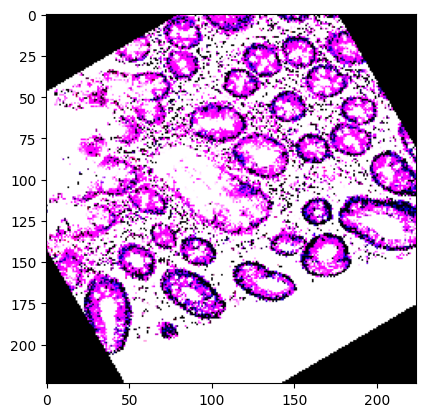

Label: 0


In [10]:
# Display image and label.
train_features, train_labels = next(iter(mhist_syn_trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T.cpu().data.numpy(), cmap="gray")
plt.show()
print(f"Label: {label}")

### Training the ConvNet7 on Synthetic dataset initialized by random real images

In [11]:
net = get_network(model = "ConvNetD7" , channel = 3, num_classes = 2, im_size=(224, 224))

In [12]:
args["device"] = "cuda"

In [13]:
train_acc, auc_list, f1_list = [], [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = mhist_syn_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    auc = 0
    f1 = 0
    batch = 0

    for i_batch, datum in enumerate(MHIST_testloader):
        batch += 1
        img = datum[0].float().to(args["device"])
        lab = datum[1].long().to(args["device"])
        
        y_pred = np.argmax(torch.sigmoid(net(img)).cpu().data.numpy(), axis = -1)
        auc += roc_auc_score(lab.cpu().data.numpy(), y_pred)
        f1 += f1_score(lab.cpu().data.numpy(), y_pred,  average="weighted")

    auc_list.append(auc / batch)
    f1_list.append(f1 / batch)
    print("Epoch = {}, Training Loss = {}, Training Accuracy = {}, F1(Test set) = {}, AUC(Test Set) = {}".format(ep, train_loss_avg, train_acc_avg, f1 / batch, auc / batch))

Epoch = 1, Training Loss = 0.7283028364181519, Training Accuracy = 0.5, F1(Test set) = 0.20258561014705417, AUC(Test Set) = 0.49914772727272727
Epoch = 2, Training Loss = 0.67412169277668, Training Accuracy = 0.51, F1(Test set) = 0.2516390339393337, AUC(Test Set) = 0.48689382694055083
Epoch = 3, Training Loss = 0.6436257511377335, Training Accuracy = 0.63, F1(Test set) = 0.350947599624326, AUC(Test Set) = 0.4958784355996837
Epoch = 4, Training Loss = 0.6231367141008377, Training Accuracy = 0.7, F1(Test set) = 0.39233854483534925, AUC(Test Set) = 0.5016376790559856
Epoch = 5, Training Loss = 0.6066832542419434, Training Accuracy = 0.74, F1(Test set) = 0.46152503999611016, AUC(Test Set) = 0.495181489338678
Epoch = 6, Training Loss = 0.5981208831071854, Training Accuracy = 0.79, F1(Test set) = 0.46867561539807523, AUC(Test Set) = 0.5120253260350743
Epoch = 7, Training Loss = 0.5840119868516922, Training Accuracy = 0.78, F1(Test set) = 0.5317143231591848, AUC(Test Set) = 0.5224628031173756

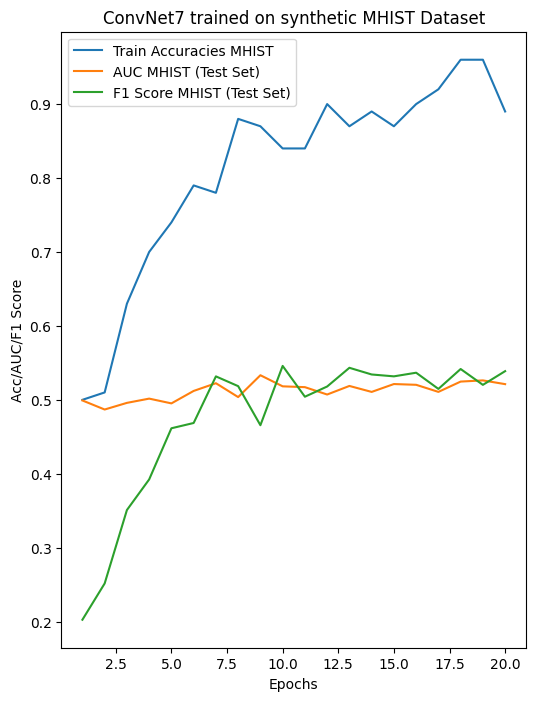

In [14]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), train_acc, label = "Train Accuracies MHIST")
plt.plot(range(1,21), auc_list, label =  "AUC MHIST (Test Set)")
plt.plot(range(1,21), f1_list, label =  "F1 Score MHIST (Test Set)")
plt.title("ConvNet7 trained on synthetic MHIST Dataset")
plt.xlabel("Epochs")
plt.ylabel("Acc/AUC/F1 Score")
plt.legend(loc = "best")
plt.show()

In [14]:
args["device"] = "cpu"

### Generating Synthetic MHIST Dataset using synthetic dataset initialized by random noise

In [21]:
args["init"] = "noise"
data_save = []
print('Hyper-parameters: \n', args)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1].item() for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args["device"])
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args["device"])

for c in range(num_classes):
    print('class c =  %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args["ipc"], channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args["device"])
label_syn = torch.tensor(np.asarray([np.ones(args["ipc"])*i for i in range(num_classes)]), dtype=torch.long, requires_grad=False, device=args["device"]).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args["init"] == 'real':
    print('initialize synthetic data from random real images')
    for c in range(num_classes):
        image_syn.data[c*args["ipc"]:(c+1)*args["ipc"]] = get_images(c, args["ipc"]).detach().data
else:
    print('initialize synthetic data from random noise')


''' training '''
# optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"], momentum=0.5) # optimizer_img for synthetic data
optimizer_img = torch.optim.SGD([image_syn, ], lr=args["lr_img"]) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args["device"])

print('%s training begins'%get_time())

for it in range(args["Iteration"]+1):


    ''' visualize and save '''
    # print("Visualizing the datatset")
    save_name = fr'{args["save_path"]}/' + 'vis_%s_%s_%s_bs%d_init_%s_%dipc_iter%d.png'%(args["method"], args["dataset"], args["model"], args["batch_syn"], args["init"], args["ipc"], it)
    image_syn_vis = copy.deepcopy(image_syn.detach().cpu())
    for ch in range(channel):
        image_syn_vis[:, ch] = image_syn_vis[:, ch]  * std[ch] + mean[ch]
    image_syn_vis[image_syn_vis<0] = 0.0
    image_syn_vis[image_syn_vis>1] = 1.0
    save_image(image_syn_vis, save_name, nrow=args["ipc"]) # Trying normalize = True/False may get better visual effects.
    # print("Synthetic datataset visualization saved")


    ''' Train synthetic data '''
    # print("Training Synthetic Datatset")
    net = get_network(args["model"], channel, num_classes, im_size).to(args["device"]) # get a random model
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=args["lr_net"])  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0
    # args["dc_aug_param"] = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.


    for ol in range(args["outer_loop"]):
        # print("outer loop epoch {}".format(ol))

        ''' update synthetic data '''
        # print("updating synthetic data")
        loss = torch.tensor(0.0).to(args["device"])
        for c in range(num_classes):
            img_real = get_images(c, args["batch_real"])
            lab_real = torch.ones((img_real.shape[0],), device=args["device"], dtype=torch.long) * c
            img_syn = image_syn[c*args["ipc"]:(c+1)*args["ipc"]].reshape((args["ipc"], channel, im_size[0], im_size[1]))
            lab_syn = torch.ones((args["ipc"],), device=args["device"], dtype=torch.long) * c


            # print("img_real", img_real.shape)
            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real, args)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step() # img optimiziner step size  = 1
        loss_avg += loss.item()

        if ol == args["outer_loop"] - 1:
            break


        ''' update network '''
        # print("updating network")
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        mHist_syn_trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=args["batch_syn"], shuffle=True, num_workers=0)
        for il in range(args["inner_loop"]):
            train_loss_avg, _ = epoch('train', mHist_syn_trainloader, net, optimizer_net, criterion, args, aug = False, optimization_steps= 50 )
        print("Training for outer epoch {} is done".format(ol))

    loss_avg /= (num_classes*args["outer_loop"])

    print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))

    if it == args["Iteration"]: # only record the final results
        data_save.append([copy.deepcopy(image_syn.detach().cpu()), copy.deepcopy(label_syn.detach().cpu())])
        torch.save({'data': data_save}, fr'{args["save_path"]}/' +  'res_%s_%s_%s_bs%d_init_%s_%dipc.pt'%(args["method"], args["dataset"], args["model"], args["batch_syn"],args["init"], args["ipc"]))


print('\n==================== Synthetic Datatset Created ====================\n')


Hyper-parameters: 
 {'dis_metric': 'cos', 'device': 'cpu', 'lr_net': 0.01, 'epoch_eval_train': 20, 'batch_train': 128, 'ipc': 50, 'num_eval': 50, 'init': 'noise', 'eval_mode': 'S', 'Iteration': 1, 'lr_img': 0.1, 'dsa_strategy': None, 'method': 'DC', 'num_exp': 1, 'save_path': 'results_path_MHIST', 'data_path': 'MHIST_Dataset', 'model': 'ConvNetD7', 'dataset': 'MHIST', 'batch_real': 128, 'batch_syn': 25, 'dsa': False, 'outer_loop': 50, 'inner_loop': 10, 'dsa_param': <utils.ParamDiffAug object at 0x0000023BAABB6100>}
class c =  0: 3090 real images
class c =  1: 1260 real images
initialize synthetic data from random noise
[2023-12-09 15:51:56] training begins
Training for outer epoch 0 is done
Training for outer epoch 1 is done
Training for outer epoch 2 is done
Training for outer epoch 3 is done
Training for outer epoch 4 is done
Training for outer epoch 5 is done
Training for outer epoch 6 is done
Training for outer epoch 7 is done
Training for outer epoch 8 is done
Training for outer e

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(mnist_syn_trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.cpu().data.numpy(), cmap="gray")
plt.show()
print(f"Label: {label}")

### Cross Architecture Generalization

In [27]:
net = get_network(model = "ConvNetD3" , channel = 3, num_classes = 2, im_size=(224, 224))

In [28]:
net.parameters

<bound method Module.parameters of ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=100352, out_features=2, bias=True)
)>

In [33]:
args["device"] = "cpu"

In [34]:
train_acc_resnet, auc_list_resnet, f1_list_resnet = [], [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = mhist_syn_trainloader, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc_resnet.append(train_acc_avg)
    auc = 0
    f1 = 0
    batch = 0

    for i_batch, datum in enumerate(MHIST_testloader):
        batch += 1
        img = datum[0].float().to(args["device"])
        lab = datum[1].long().to(args["device"])
        
        y_pred = np.argmax(torch.sigmoid(net(img)).cpu().data.numpy(), axis = -1)
        auc += roc_auc_score(lab.cpu().data.numpy(), y_pred)
        f1 += f1_score(lab.cpu().data.numpy(), y_pred,  average="weighted")

    auc_list_resnet.append(auc / batch)
    f1_list_resnet.append(f1 / batch)
    print("Epoch = {}, Training Loss = {}, Training Accuracy = {}, F1(Test set) = {}, AUC(Test Set) = {}".format(ep, train_loss_avg, train_acc_avg, f1 / batch, auc / batch))

Epoch = 1, Training Loss = 37.646944507956505, Training Accuracy = 0.46, F1(Test set) = 0.20092240972632364, AUC(Test Set) = 0.5
Epoch = 2, Training Loss = 31.756518363952637, Training Accuracy = 0.56, F1(Test set) = 0.20092240972632364, AUC(Test Set) = 0.5
Epoch = 3, Training Loss = 40.47140121459961, Training Accuracy = 0.42, F1(Test set) = 0.20092240972632364, AUC(Test Set) = 0.5
Epoch = 4, Training Loss = 27.461753726005554, Training Accuracy = 0.47, F1(Test set) = 0.20092240972632364, AUC(Test Set) = 0.5
Epoch = 5, Training Loss = 16.859389781951904, Training Accuracy = 0.51, F1(Test set) = 0.2770589392263025, AUC(Test Set) = 0.5105779954340919
Epoch = 6, Training Loss = 17.63096332550049, Training Accuracy = 0.45, F1(Test set) = 0.20662654233009536, AUC(Test Set) = 0.5007845777047584
Epoch = 7, Training Loss = 7.045536518096924, Training Accuracy = 0.6, F1(Test set) = 0.22295849302540943, AUC(Test Set) = 0.5043956622771493
Epoch = 8, Training Loss = 13.456822633743286, Training A

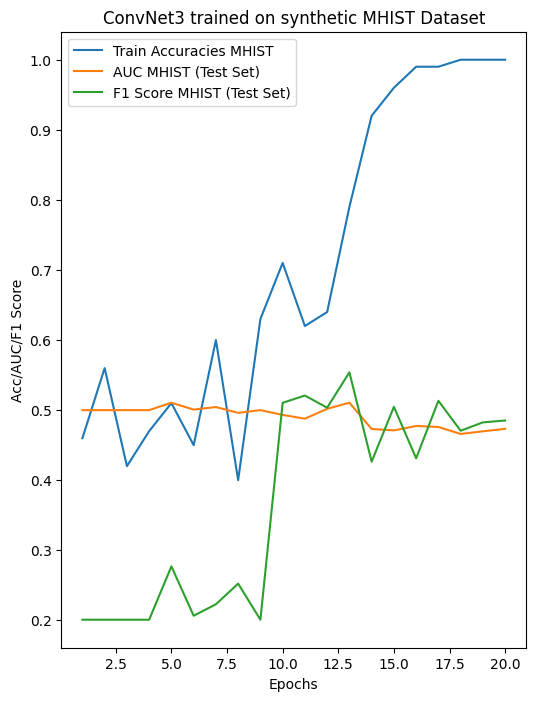

In [35]:
plt.figure(figsize = (6,8))
plt.plot(range(1,21), train_acc_resnet, label = "Train Accuracies MHIST")
plt.plot(range(1,21), auc_list_resnet, label =  "AUC MHIST (Test Set)")
plt.plot(range(1,21), f1_list_resnet, label =  "F1 Score MHIST (Test Set)")
plt.title("ConvNet3 trained on synthetic MHIST Dataset")
plt.xlabel("Epochs")
plt.ylabel("Acc/AUC/F1 Score")
plt.legend(loc = "best")
plt.show()

In [ ]:
train_acc, auc_list, f1_list = [], [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = trainloader_MHIST, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    auc = 0
    f1 = 0
    batch = 0

    for i_batch, datum in enumerate(testloader_MHIST):
        batch += 1
        img = datum[0].float().to(args["device"])
        lab = datum[1].long().to(args["device"])
        
        # y_pred = np.argmax(tf.math.sigmoid(net(img)).numpy(), axis = -1)
        y_pred = np.argmax(torch.sigmoid(net(img)).cpu().data.numpy(), axis = -1)
        auc += roc_auc_score(lab.cpu().data.numpy(), y_pred)
        f1 += f1_score(lab.cpu().data.numpy(), y_pred,  average="weighted")

    auc_list.append(auc / batch)
    f1_list.append(f1 / batch)
    print("Epoch = {}, Training Loss = {}, Training Accuracy = {}, F1(Test set) = {}, AUC(Test Set) = {}".format(ep, train_loss_avg, train_acc_avg, f1 / batch, auc / batch))

In [ ]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, MNIST_testloader, MNIST_trainloader = get_dataset(dataset = 'MNIST', data_path = "MNIST_Dataset")

In [ ]:
train_acc, auc_list, f1_list = [], [], []
for ep in range(1,21):
    train_loss_avg, train_acc_avg = epoch(mode = 'train', dataloader = trainloader_MHIST, net = net , optimizer = torch.optim.SGD(params = net.parameters(), lr=args["lr_net"]), criterion = nn.CrossEntropyLoss(), args = args, aug = None, optimization_steps = None)
    train_acc.append(train_acc_avg)
    auc = 0
    f1 = 0
    batch = 0

    for i_batch, datum in enumerate(testloader_MHIST):
        batch += 1
        img = datum[0].float().to(args["device"])
        lab = datum[1].long().to(args["device"])
        
        y_pred = np.argmax(torch.sigmoid(net(img)).cpu().data.numpy(), axis = -1)
        auc += roc_auc_score(lab.cpu().data.numpy(), y_pred)
        f1 += f1_score(lab.cpu().data.numpy(), y_pred,  average="weighted")

    auc_list.append(auc / batch)
    f1_list.append(f1 / batch)
    print("Epoch = {}, Training Loss = {}, Training Accuracy = {}, F1(Test set) = {}, AUC(Test Set) = {}".format(ep, train_loss_avg, train_acc_avg, f1 / batch, auc / batch))